# Моделирование методом Монте-Карло

В этом блокноте и статье к нему мы рассмотрим простые варианты использования метода Монте-Карло для оптимизации некоторых систем.

Загружаем библиотеки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Пример "Кассы"

В данном примере нам надо рассчитать оптимальное количество касс, которые могут обслужить всех покупателей в определенном интервале времени. 

Самый простой вариант, когда событтия находятся в одной размерности. Например, это дни, часы и месяцы. В нашем случае это магазин (билетная касса и тд) и нам надо рассчитать оптимальное количество открытых касс в час пик (с 17 до 18 часов). У нас есть две независимые переменные: статистика потока клиентов количества клиентов в час и кличество клиентов которых может обслужить одна касса. Если у нас есть статистика времнеи обслуживания одного клиента, то лучше перевести ее в показатель производительности кассы в час. Это существенно упростит моделирование. 

В фйле `MC_data.xlsx` содежаться история потока клиентов за год в интервале времени с 17 до 18 часов (лист "market") и производительность касс в этот же интевал времени (5 касс, статистика за год). 

Загрузим и изучим статистики.

In [2]:
df_market=pd.read_excel('MC_data.xlsx', sheet_name='market')
df_kassir=pd.read_excel('MC_data.xlsx', sheet_name='kassir')

In [3]:
df_market.head()

,Поток клиентов
0,58
1,51
2,48
3,79
4,33


In [4]:
df_market.describe()

,Поток клиентов
count,365.000000
mean,49.071233
std,14.811837
min,21.000000
25%,37.000000
50%,47.000000
75%,60.000000
max,87.000000


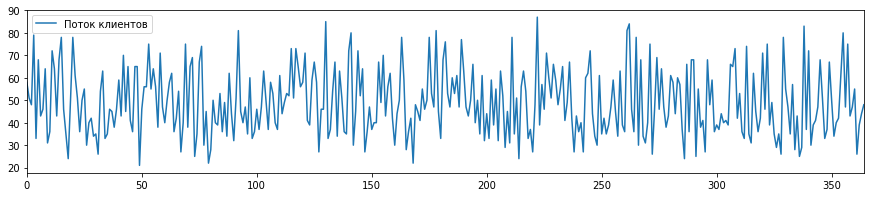

In [5]:
df_market.plot(figsize=(15,3));

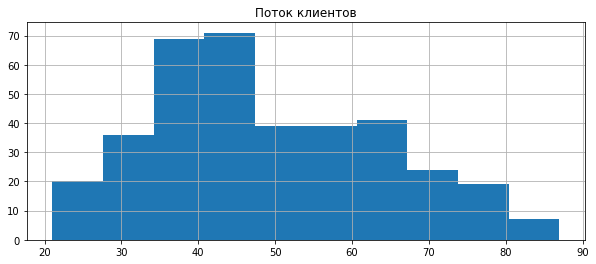

In [6]:
df_market.hist(figsize=(10,4));

In [7]:
df_market.mode()

,Поток клиентов
0,36


Мы видим, что случайная величина (поток клиентов) имеет треугольное распределение с модой 36 клиентов/час. 

In [8]:
df_kassir.describe()

,Производительность кассы
count,1825.000000
mean,26.003836
std,6.445664
min,15.000000
25%,21.000000
50%,25.000000
75%,31.000000
max,44.000000


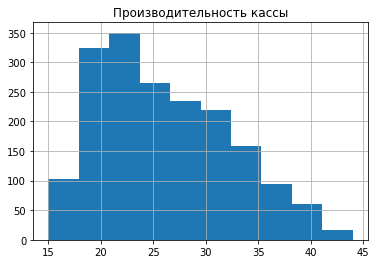

In [9]:
df_kassir.hist();

In [10]:
df_kassir.mode()

,Производительность кассы
0,21


Статистика производительности касс также треугольное распределение с модой 21 клиент/час. 

Сгенерируем по 1000 эксземпляров случайных значений, которые будут соответствовать данным распределениям. Ниже Вы сможете найти примеры создания других видов распределений.

Мы будем использовать функции, которые генерируют дробные случайные значения, но округлим их до целых значений. Это не сильно повлияет на качество модели, но упростит нам задачу. 

- left - минимальное значение
- right - максимальное значение
- mode - наиболее часто встречаемое значение, мода

In [11]:
size=1000
market = np.random.triangular(left = 21, mode = 36, right = 87, size = size).astype(int)
kassir = np.random.triangular(left = 15, mode = 21, right = 44, size = size).astype(int)

Взглянем на результат моделирования. 

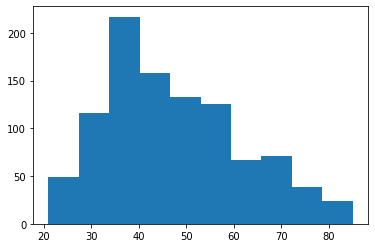

In [12]:
plt.hist(market);

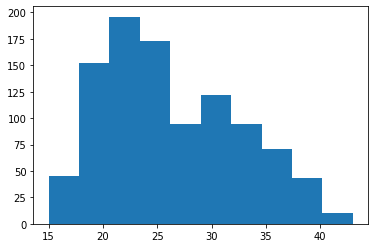

In [13]:
plt.hist(kassir);

Моделируем работу двух касс при случайном потоке клиентов, выполняем 1000 экспериментов.

Списки nupmy позволяют осуществлять поэлеменнтные операции обращаясь к списку по имени. В данном случае, мы умножаем все элементы списка kassir на два и вычитаем из каждого элемента соответсвующее значение потока клиентов. Далее, считаем какое количество итоговых элементов больше нуля. Те мы смогли обслужить клиентов. 

In [14]:
((kassir*2-market)>0).sum()

612

Только в 621 случае мы смогли облсужить всех клиентов.

Моделируем работу трех при трех кассах на этом же потоке клиентов. А затем 4 кассы.

In [15]:
((kassir*3-market)>0).sum()

921

In [16]:
((kassir*4-market)>0).sum()

995

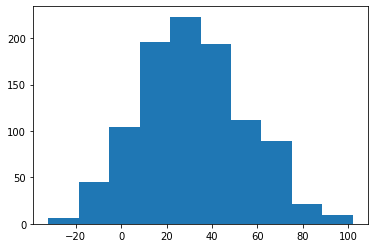

In [17]:
plt.hist((kassir*3-market));

Мы видим, что три кассы обеспечивают обслуживание всех клиентов в 91% случаев. 4 кассы позволят обслужить всех клиентов в 98% случаев. Здесь встает вопрос, насколько это будет экономически целесообразно держать 4 кассы, при том, что в большинстве случаев будут недозагружены и три кассы. 

Для более справедливых результатов можно отдельно моделировать производительность каждой из касс.

In [18]:
kassir2 = np.random.triangular(left = 15, mode = 20, right = 44, size = size).astype(int)
kassir3 = np.random.triangular(left = 15, mode = 20, right = 44, size = size).astype(int)
kassir4 = np.random.triangular(left = 15, mode = 20, right = 44, size = size).astype(int)

In [19]:
((kassir+kassir2-market)>0).sum()

625

In [20]:
((kassir+kassir2+kassir3-market)>0).sum()

945

In [21]:
((kassir+kassir2+kassir3+kassir4-market)>0).sum()

1000

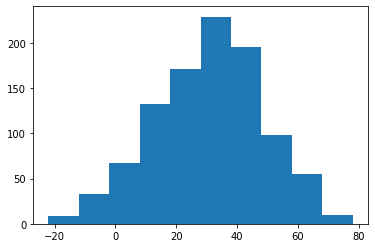

In [22]:
plt.hist((kassir+kassir2+kassir3-market));

При этом, мы получаем схожие результаты.

# Играем против казино

В прошлом случае с кассами мы имели классический пример марковского процесса. Когда размер потока между днями никак не связан. Боее сложный вариант для моделирования, когда следующее состояние объекта определяется предыдущим. Здесь процесс моделирования несколько изменяется.

Представим, что мы играем рпотив казино и наши шансы составляют 60%. Играем строго 100 раз. Ставка составлет 50% от суммы на руках. Здесь нам придется провести моделирование 100 игр некоторое количество раз. Сумма на руках будет определять следующий ход.

Напишем небольшую функцию, которая будет моделировать данный процесс (один цикл игр).

In [23]:
def kazino(start, level=50): #передаем стартовую сумму и наши шансы. По умолчанию 50%
    # генерируем исходы рулетки (шансов) для 100 игр, равномерное распределение
    M1_sample = np.random.uniform(low = 0, high = 100.0, size = 100)
    for i in range(len(M1_sample)): 
        #если значение исхода меньше уровня наших шансов - то увеличиваем сумму на руках на 50%
        if M1_sample[i]<level:
            start+=start/2
        else: # если проигрываем, теряем половину суммы, которая есть на руках
            start-=start/2
    return start

In [24]:
result=[] # сохраним каждый из случаев моделирования
for i in range(100): # выполняем 100 раз моделирование цикла игр (один цикл 100 ходов)
    result.append(kazino(100, 60)) #стартовая сумма 100 долл и шансы (60%)
result=np.array(result) # преобразуем список в список numpy для упрощения следующих операций

In [25]:
result.mean()

79362.17778472048

In [26]:
result.max()

5331532.097460406

Какой замечательный средний и максимальный выигрыш!

In [27]:
(result<100).sum()

83

In [28]:
(result<1).sum()

44

Но в 72 случаях мы ушли из казино с суммой меньше стартовой. А в 33 случаях ушли с суммой меньше доллара.

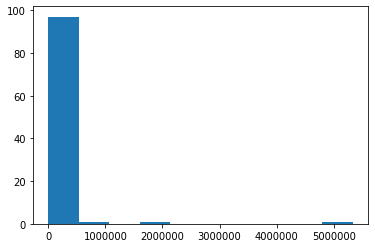

In [29]:
plt.hist(result);

Данный результат удобнее анализировать на гистограмме. Один большой выигрыш формирует такие замечательные средние показатели.

Вывод - не играйте долго против казино. Лучше, вообще не играйте даже с шансами 60%. :-)

# Более сложный практический пример

Продолжим рассмотрение ситуаций,когда может быть полезна модель Монте-Карло и надо учитывать результаты предыдущих состояний. Например, нам надо оптимизировать точку заказа и объем заказа. 

Попробуйте найти оптимальное значение изменяя параметры `point_order` (точка заказа) и `order` (размер заказа). Размер заказа определяет также начальный запас. При этом, определеа стоимость единицы товара (20 рублей), себестоимость (15 рублей). Прибыль - это разница между ценой и себестоимостью. Также есть плата за хранение единицы товара (1 рубль за период).

In [30]:
point_order=100 # точка заказа
order=800 # размер заказа
price=20 #стоимость товара 
cost_price=15 # себестоимость товара 
cost_stock=1 # стоимость хранения

size=1000 # количество экспериментов
days=30 # продолжительность одного цикла

result=[] # только исходы по циклам
result_full=[] # полная информация, включая исходы по дням, можно использовать для дополнительного анализа

for i in range(size): 
    # моделируем случайное распределение спроса
    market = np.random.triangular(left = 50, mode = 75, right = 140, size = days).astype(int)
    money=0 # начинаем с нулевой суммой
    stock=order # стартовый запас 
    rt=[] # временный список для хранения результатов прибыли по дням
    for d in range(days): # моделируем по дням
        if market[d]<stock: # если запас больше спроса 
            money+=market[d]*price-cost_stock*stock # добавим деньги от продажи и вычтем стоимость хранения
            stock-=market[d] # уменьшим запас
        else: # если спрос больше запаса
            money+=stock*price-cost_stock*stock # продадим только то, что есть
            stock=0 # обнуляем склад
        # проверяем, пора ли делать заказ
        if stock<=point_order:
            money-=order*cost_price # вычтем из прибыли плату за товар
            stock+=order # добавим товар на склад
        rt.append(money) # накапливаем историю по финансам
    result_full.append(rt) # сохраняем полную историю по состоянию финансов
    result.append(money) # итоговый результат по финансовому состоянию одного цикла

Результаты можем оценить по гистограмме и ориентируясь на количество случаев, когда итоговая прибыль больше нуля.
Например, с точкой заказа 100 единиц и заказом 800 единиц, в 300 случаях мы уходим в минус. Хотя средняя прибыль больше 1000 рублей. Еще одно подтверждение того, что среднее несет недостаточно информации. 

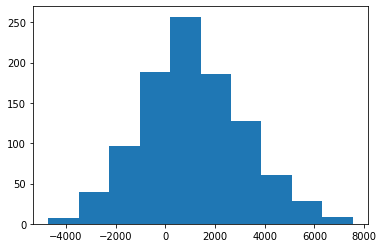

In [31]:
plt.hist(result);

In [32]:
np.array(result).mean()

1117.265

In [33]:
(np.array(result)>0).sum()

700

Данный конкретных случай можно улучшать, добавляя реализма:
- Добавить стоимость заказа
- Добавить штраф за отсутсвие товара 
- Добавить вариацию сроков поставки и тд.

По факту, мы можем моделировать совершенно любые системы. Также можем использовать различные распределения. О них ниже.

# Другие распределения
Которые можно использовать в имитационном моделировании.

## Нормальное распределение

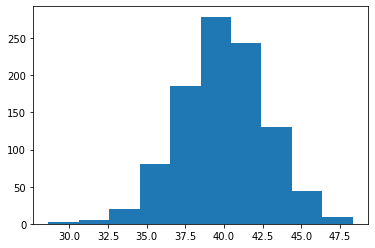

In [34]:
speed = np.random.normal(loc = 40.0, scale = 2.76, size = 1000)
# loc - среднее значение, scale - стандартное отклонение
plt.hist(speed);

## Равномерное распределение

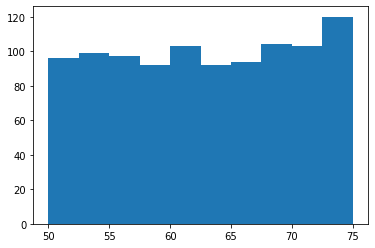

In [35]:
M1_sample = np.random.uniform(low = 50.0, high = 75.0, size = 1000)
plt.hist(M1_sample);

## Гамма распределение

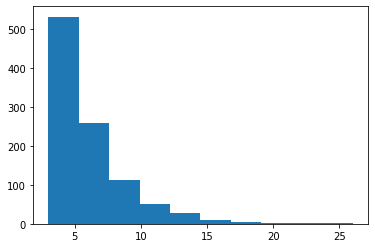

In [36]:
from scipy.stats import gamma
gamma_distribution = gamma(loc = 3, scale = 3, a = 1) # инициация распределения
plt.hist(gamma_distribution.rvs(1000)); # генерация случайных значений

## Дискретное распределение

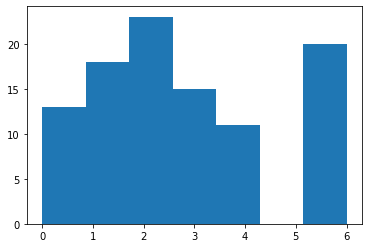

In [37]:
from scipy import stats
xk = np.arange(7) # список от 0 до 6
pk = (0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2) # частота, с котрой будут выпадать значения списка выше
custm = stats.rv_discrete(name='custm', values=(xk, pk)) # инициация распределения

R = custm.rvs(size=100) # генерация 100 случайных значений
plt.hist(R, bins=7); # bins - карманы гистограммы